# Data Cleaning & Feature Extraction

In this notebook, load the different data sources explored earlier and clean them for our approaches. We will then create a very basic predicition system to check for 

In [39]:
import pandas as pd
import numpy as np
import sys, os
from datetime import datetime
sys.path.insert(1, '..')
import recommender as rcmd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import entropy
%matplotlib inline

Next we will load a set of relevant data sources

In [40]:
nf = rcmd.news.FPNewsFeed('https://www.ft.com/business-education?format=rss', col_map={'link': 'article_link', 'summary': 'summary', 'title': 'headline', 'published': 'date'}, filter=True)
news_meta, df_news = nf.news()
sm = rcmd.stocks.FMPStatements()
tk = rcmd.stocks.AlphaVantageTicker()
df_stocks = rcmd.contrib.fmp_api.profile.list_symbols()

In [41]:
df_stocks['symbol'].values

array(['SPY', 'CMCSA', 'KMI', ..., 'ZWZZT', 'ZXZZT', 'ZYME'], dtype=object)

## Data Extraction Pipeline

Our goal will be to create a pipeline that can extract data for a specific stock we select from `df_stocks`. This includes the last balance-sheet statements as well as historic stock prices. We should also search for historic news that we can use for the training process.

In [42]:
def find_stock(name, stocks):
    return stocks[stocks['name'].str.contains(name, case=False)]

find_stock('facebook', df_stocks)

,name,price,symbol
21,Facebook Inc.,186.92,FB


In [52]:
# some stock selection functions (this gathers all available data and might take a while...)
#df = sm.merge_records(df_stocks['symbol'].values)
#df.to_csv('../data/statements.csv')

# load the relevant data
df = pd.read_csv('../data/statements.csv')

In [53]:
# create an index based on year and quarter
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df.head()

,Unnamed: 0,assets_tax,assets_total,assets_total_current,assets_total_noncurrent,bookvalue_share_growth,buybacks,capital_expenditure,cash,cash_marketcap_ratio,...,revenue_costs,revenue_deffered,revenue_growth,revenue_share_growth_10y,revenue_share_growth_3y,revenue_share_growth_5y,shareholder_equity,symbol,year,quarter
0,0,331000.0,250873000.0,15115000.0,102410000.0,NaN,137610000.0,-139000.0,226734000.0,0.1833,...,0.0,0.0,0.0,NaN,NaN,NaN,79567000.0,myov,2019,2
1,1,524000.0,172977000.0,6185000.0,96670000.0,-0.9019,27248000.0,-518000.0,156074000.0,0.0337,...,0.0,0.0,0.0,NaN,NaN,NaN,4334000.0,myov,2019,1
2,2,767000.0,201670000.0,5504000.0,99061000.0,NaN,38013000.0,-328000.0,183003000.0,0.0750,...,0.0,0.0,0.0,NaN,NaN,NaN,46735000.0,myov,2018,4
3,3,767000.0,168166000.0,4633000.0,46095000.0,NaN,75001000.0,-193000.0,154317000.0,0.0638,...,0.0,0.0,0.0,NaN,NaN,NaN,74101000.0,myov,2018,3
4,4,855000.0,154348000.0,4156000.0,45270000.0,NaN,79963000.0,-197000.0,143635000.0,0.0337,...,0.0,0.0,0.0,NaN,NaN,NaN,60155000.0,myov,2018,2


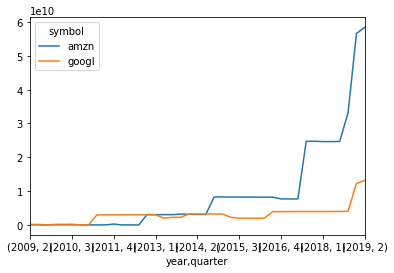

In [60]:
# print out example data
def get_feature(symbol, feat):
    return df[df['symbol'] == symbol.lower()].set_index(['year', 'quarter'])[feat].rename(symbol).sort_index(ascending=True)

def get_features(symbols, feat):
    return df[df['symbol'].isin(symbols)].pivot_table(index=['year', 'quarter'], columns='symbol', values=feat).sort_index(ascending=True)

# plot features
get_features(['googl', 'amzn'], 'debt_longterm').plot()

**Stock Data**

Now that we have loaded the relevant Stock Statements, lets load the historical stock data (daily resolution) - in this case loading from file (requires that the `data/download_stocks.sh` script has been executed.

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


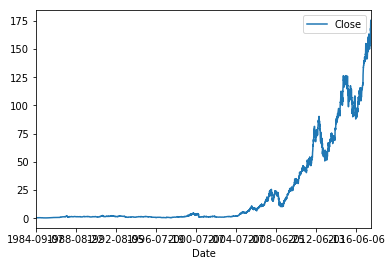

In [61]:
import glob
import os
def list_stocks(type='stock'):
    '''Generates a list of available historic stock data.'''
    fldr = 'Stocks' if type == 'stock' else 'ETFs'
    path = '../data/{}'.format(fldr)
    # list all fiels in direcotry
    files = glob.glob(os.path.join(path, '*.txt'))
    names = pd.Series(files).apply(lambda f: os.path.basename(f).split('.')[0])
    #return pd.DataFrame({'symbol': names, 'file': files})
    return dict(zip(names, files))

def load_stock_file(file, type='stock'):
    # list all fiels in direcotry
    return pd.read_csv(file)
    
stocks = list_stocks('stock')
#stocks
dfa = pd.read_csv(stocks['aapl'])
dfa.set_index('Date')[['Close']].plot();
dfa.head()

In [62]:
# sample list of stock elements
sample = np.random.choice(list(stocks.keys()), 30)
#sample = list(stocks.keys())[:10]

# Note: integrated into the cache class in the recommender
def load_stock_list(symbols, stocks=None, ticker=None):
    '''Loads a dataframe with the given stock data.
    
    Args:
        symbols (list): List of symbol names to load
        stocks (dict): Stock name dictionary (if None, load with default vals)
        
    Returns:
        DataFrame in default stock format with additional symbol column
    '''
    df_stocks = []
    for symbol in symbols:
        # load stock data
        if symbol in stocks:
            try:
                df_stock = pd.read_csv(stocks[symbol])
            except:
                continue
        else:
            try:
                df_stock = ticker.historic(symbol, start=None, resolution='daily').reset_index()
            except:
                print('Could not load {}'.format(symbol))
                continue
            
        # check if empty
        if df_stock is None or df_stock.empty == True:
            continue
        
        # add
        df_stock['symbol'] = symbol
        df_stock.columns = [col.lower() for col in df_stock.columns]
        df_stocks.append(df_stock)
    
    
    df = pd.concat(df_stocks, axis=0)
    return df

df_stocks = load_stock_list(sample, stocks, ticker=rcmd.stocks.AlphaVantageTicker())
df_stocks.sample(10)

,date,open,high,low,close,volume,openint,symbol
1668,2011-10-11,5.4614,5.5781,5.3250,5.5488,130370,0,bfr
736,2009-12-24,9.1120,9.2133,9.0701,9.1921,457157,0,aod
781,2008-04-04,24.7500,25.4100,24.2700,24.7500,22099,0,novt
2771,2016-03-02,31.8730,31.9100,31.7050,31.9010,583138,0,bt
714,2015-09-23,20.5720,21.1720,20.2950,20.8420,152695,0,aldw
281,2006-04-07,11.1390,11.1390,11.0440,11.0440,25338,0,cet
2719,2015-12-15,21.0590,21.0590,20.6080,20.6260,114866,0,lby
923,2008-10-27,8.5399,8.6829,8.5274,8.6468,42282,0,cet
1825,2012-11-15,9.8820,9.9550,9.5340,9.9020,647504,0,core
1715,2012-04-16,6.3363,6.3712,6.1279,6.1541,96186,0,linc


In [63]:
# TODO: select historic news and scrap entire news articles? + Use Embeddings to integrate them

## Feature Extraction

After we have loaded the data and can extract relevant portions, we want to convert it into training data. This requires data to have a single embedding and to use structured time information. As well as combine past data with future performance to have labels for the training process.

The goal of the stock prediction system is to use current information:

* Last Statements from a given company
* Recent stock history

To predict the outcome of the stock data (i.e. would an invest in the stock be profitable over time horizon X). This leaves us with the following parameters for the data training:

`1.` Time Horizon of prediction (How long do we want to look in the future?)

`2.` Amount of Recent Data (Do we just give the current state of a windows of data from the past X days/month?)

`3.` Cliping of target values (in which interval is a stock profitable, neutral or unprofitable?)

`3.` Normalization of the Data (Do we use absolute values of differences?)

`4.` Smoothing of the Data (Do we take the stock closing price on a single day or of a week?)

The last two questions are probably easiest to answer. Since all stocks have different values (i.e. different start prices of the stock and current statement values) and these values do not have an impact on our prediction (if a \\$10 stock rises to \\$200 this is a much better investment than a \\$1000 stocks rise to \\$1500). We will therefore adopt a normalization that takes the current stock price as a starting point and computes percental difference from there. This will provide a normalized scale across all stocks.

For the smoothing we might use a time windows that is dependent on the length of the prediction (e.g. +/- 3 days for a quarter prediction and +/- 1 Week for a year prediction).

To verify this, we will write a function to normalize the data and given a time horizon create a distribution of the target values.

In [64]:
# Function to align the statements of a company with the 
def normalize_window(df, days_back, days_target, smooth_interval):
    '''Normalizes the data in the given window and returns the values and the target
    
    Args:
        df (np.Array): Numpy Array that contains only one values column
        days_back (int): How many days of history data should be included
        days_target (int): How many days shoudl the target value lie ahead
        smooth_interval (int): Interval in days around the target value that is used for smoothing (if None use just target day)
        
    Returns:
        Numpy array that has the normalized data of length `days_back` and an additional datapoint with the target value
    '''
    # retrieve the normalized data
    norm = df[days_back - 1]
    df = np.divide(df, norm) - 1
    
    # retrieve the input stock values
    vals = df[:days_back]
    # TODO: might call additional compaction (e.g. only weekly data)
    
    # calculate the target value
    target_loc = days_back + days_target - 1
    if smooth_interval is None:
        target = df[target_loc]
    else:
        target = df[(target_loc - smooth_interval):(target_loc + smooth_interval + 1)].mean()
    
    # return result vector
    return np.concatenate([vals, [target]])
    
# alias for numpy function
as_strided = np.lib.stride_tricks.as_strided
    
def create_dataset(df, days_back, days_target, smooth_interval, value_col='close', jump_size=7):
    '''Creates a dataset from the given stock data.
    
    Args:
        df (DataFrame): DataFrame of stock prices. Each Row should contain these columns: `[symbol, date, values]`
        value_col (str): Name of the column that contains the relevant stock data
        days_back (int): How many days of history data should be included
        days_target (int): How many days shoudl the target value lie ahead
        smooth_interval (int): Interval in days around the target value that is used for smoothing
        jump_size (int): Number of days to jump between different data points
    
    Returns:
        DataFrame that should contain the relevant stock information. It contains the following columns: `[date, *data, target, symbol]`.
        `date` is thereby the starting date before the prediction.
        `data` are a list of columns from newest to oldest (number is defined by `days_back`)
           |------------------|----------------------------|
         date    data    date+days_back                 target
    '''
    # iterate through all symbols in the df
    symbols = df['symbol'].unique()
    # make sure that date column is converted
    if df['date'].dtype == 'object':
        df['date'] = df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        
    # calculate window size and the column names
    win = days_back + days_target + (smooth_interval if smooth_interval is not None else 0)
    cols = ["day_{}".format(i+1) for i in range(days_back)] + ["target"]
    
    # order symbol-df for time and perform sliding window
    df_symbol = df['symbol'].str.lower()
    df_norm = []
    for symbol in symbols:
        # retrieve partial df
        df_sym = df[df_symbol == symbol.lower()].sort_values(by='date').set_index('date')[[value_col]]
        df_arr = np.copy(df_sym.to_numpy())
        
        # sliding window
        st = df_arr.strides   # number of bytes for as_stride to jump
        sz = np.ceil((len(df_arr) - (win-1)) / jump_size)
        if sz < 1: continue
        wnds = as_strided(df_arr, (int(sz), win), (st[0] * jump_size, st[1] * 1))

        # apply normalization
        df_res = np.apply_along_axis(lambda wnd: normalize_window(wnd, days_back, days_target, smooth_interval), axis=1, arr=wnds)
        df_res = pd.DataFrame(df_res)
        
        # add columns and index
        df_res.columns = cols
        df_res.index = df_sym.index[:-(win-1)][0::jump_size]
        df_res['symbol'] = symbol
        
        # add to result
        df_norm.append(df_res)
    
    # add data to target
    df_norm = pd.concat(df_norm, axis=0)
    
    return df_norm

# Note: functions are added into rcmd (`learning.preprocess`)

In [65]:
df_norm = create_dataset(df_stocks, 7, 30, 3)
df_norm.head()

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,target,symbol
date,,,,,,,,,
2012-11-20,-0.040156,-0.016688,-0.045458,-0.034941,-0.008779,-0.002086,0.0,0.126665,aldw
2012-11-30,-0.111407,-0.119169,-0.097609,-0.067817,-0.051431,-0.007605,0.0,0.050882,aldw
2012-12-11,-0.071756,-0.050142,-0.050142,-0.050942,-0.046503,-0.017320,0.0,0.047948,aldw
2012-12-20,-0.004362,0.009832,0.018140,0.029495,0.002700,-0.050474,0.0,0.138465,aldw
2013-01-02,0.195981,0.148633,0.087942,0.073312,0.060289,0.037701,0.0,0.345200,aldw


                data
2014-07-24 -0.010600
2014-07-25  0.005738
2014-07-26 -0.014665
2014-07-27  0.009564
2014-07-28  0.009086
2014-07-29 -0.006217
2014-07-30  0.000000
2014-08-30  0.067165
Reference Date: 2014-07-31 00:00:00 - Value: 12.469000000000001


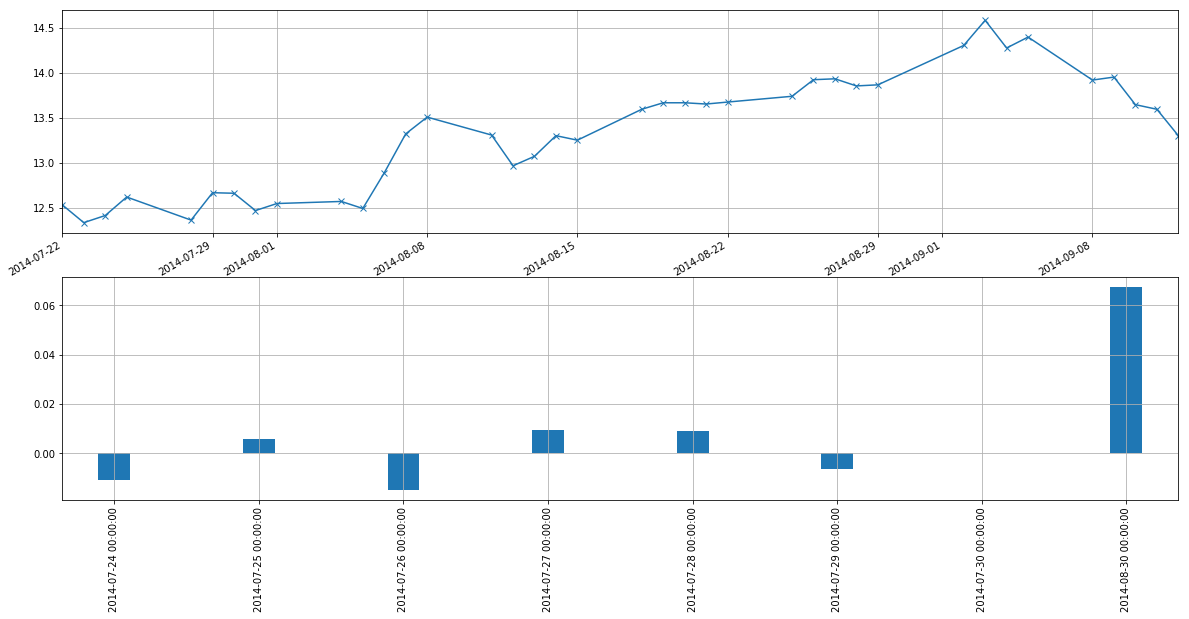

In [70]:
# visualize a stock of normalized data
def visualize(symbol, df_norm=df_norm, df_stocks=df_stocks):
    # retrieve relevant data
    dfn = df_norm[df_norm['symbol'] == symbol]
    dfs = df_stocks[df_stocks['symbol'] == symbol].set_index('date')['close']
    
    # helper
    days_back = 7
    days_target = 30
    smooth = 3
    
    # select data row
    dfn = dfn.sample(1).drop('symbol', axis=1)
    date = dfn.index[0]
    idx = [date + pd.DateOffset(i) for i in range(0, days_back)] + [date+pd.DateOffset(days_back+days_target)]
    dfn.columns = pd.to_datetime(idx)
    dfn = dfn.transpose()
    dfn.columns = ['data']
    print(dfn)
    
    # retrieve relevant stock data
    dfs = dfs[(dfs.index >= (idx[0] - pd.DateOffset(2))) & (dfs.index <= (idx[-1] + pd.DateOffset(smooth+10)))]
    #dfn.index = list(dfs.index[:days_back]) + list(dfs.index[-1:])

    date = date + pd.DateOffset(days_back)
    print("Reference Date: {} - Value: {}".format(date, dfs.loc[date]))
    
    # create two plots
    #dfs = dfs.reindex(index=dfs.index.union(dfn.index))
    #dfn = dfn.reindex(index=dfn.index.union(dfs.index))
    fig, axs = plt.subplots(2, 1, sharex=False, figsize=(20, 10))
    dfn.plot.bar(ax=axs[1], legend=None, grid=True, width=0.22)
    dfs.plot(ax=axs[0], legend=None, grid=True, marker='x')
    
    
    
visualize('aldw')

> Note that the dates in the charts do not match exactly, as we do not account for weekday/weekend differences but simply for offsets

**Target Value Distributions**

Next we should understand what we actually want to measure. Therefore we will generate normalized training data in different strides and measure the distribution of target values. This will allow us to determine the smoothing and window parameter.

Since the target values are continuous, we have to use a bucketing approach (or density estimation based on a prior distribution) to identify relevant values. Due to computation power constraints, we will have to use a sub-sample of the the relevant stock data.

In [71]:
# load the entire df_stocks set
sample = np.random.choice(list(stocks.keys()), 1000)
df_stocks = load_stock_list(sample, stocks, ticker=rcmd.stocks.AlphaVantageTicker())

In [72]:
def get_target_dist(back, target, smooth, jump, df_stocks=df_stocks):
    '''Function to retrieve the target distribution of values from different parameters'''
    # calculate the dataset
    df_norm = create_dataset(df_stocks, back, target, smooth, jump_size=jump)
    
    # calculate + visualize (note generate different plots)
    fig, axs = plt.subplots(2, 1, figsize=(20, 5))
    df_norm['target'].plot.kde(xlim=(-5, 5), ax=axs[0])
    df_norm['target'].plot.hist(bins=100, ax=axs[1], range=(-5, 5))
    fig.suptitle('Dist: {} back - {} target - {} smoothing - {} jumps'.format(back, target, smooth, jump), fontsize=16)
    plt.show()
    
#get_target_dist(7, 30, 3, 7)

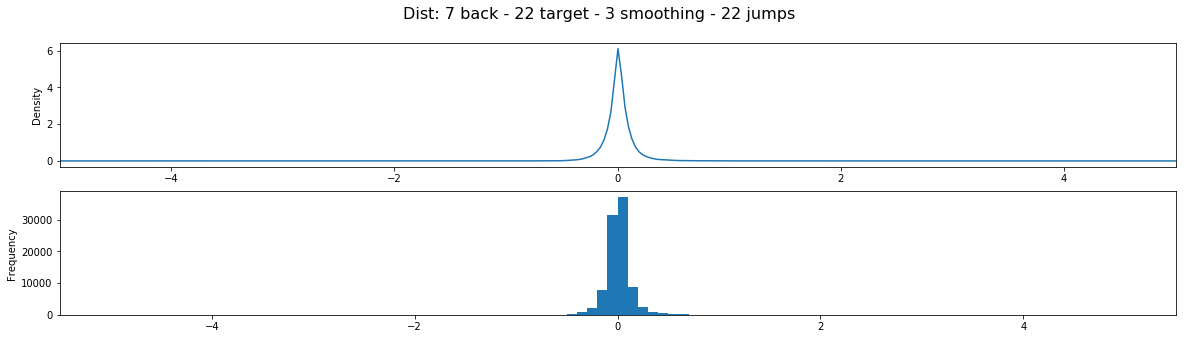

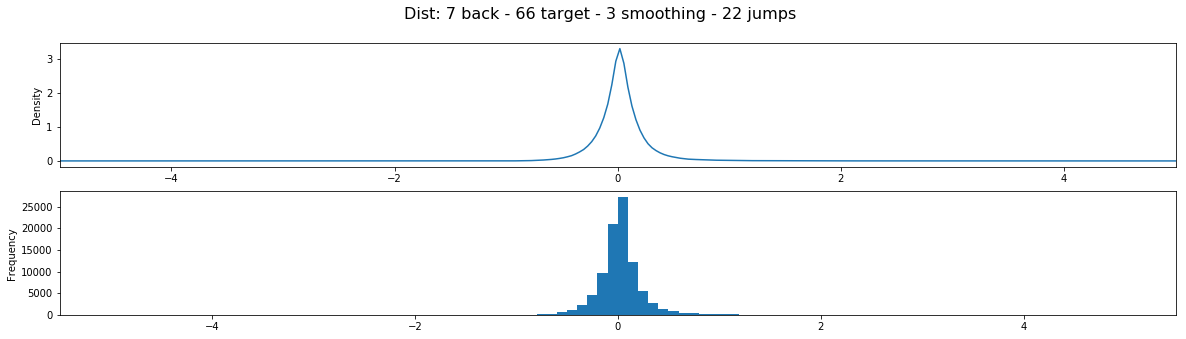

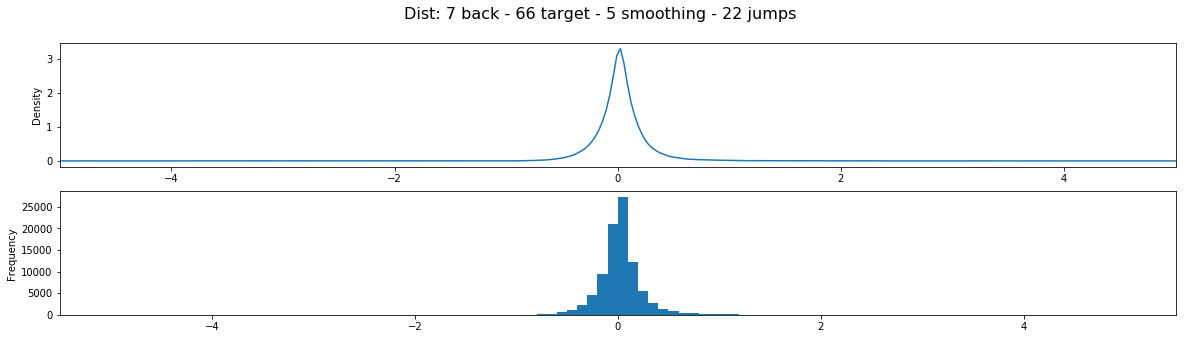

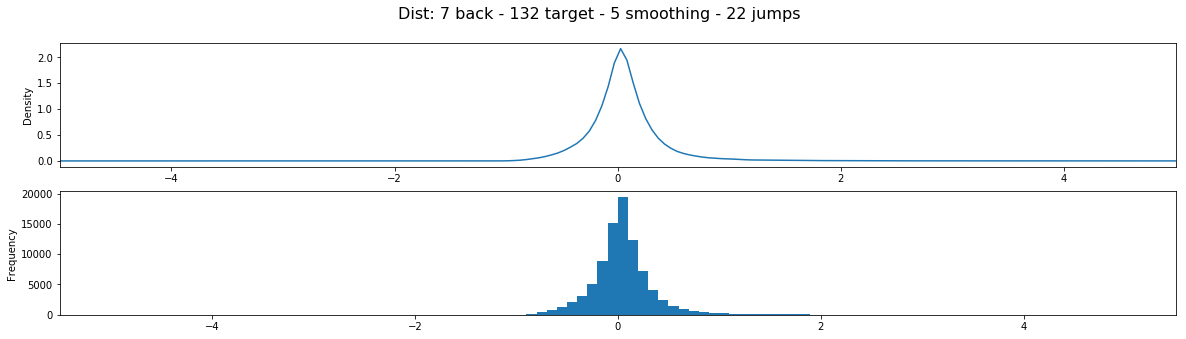

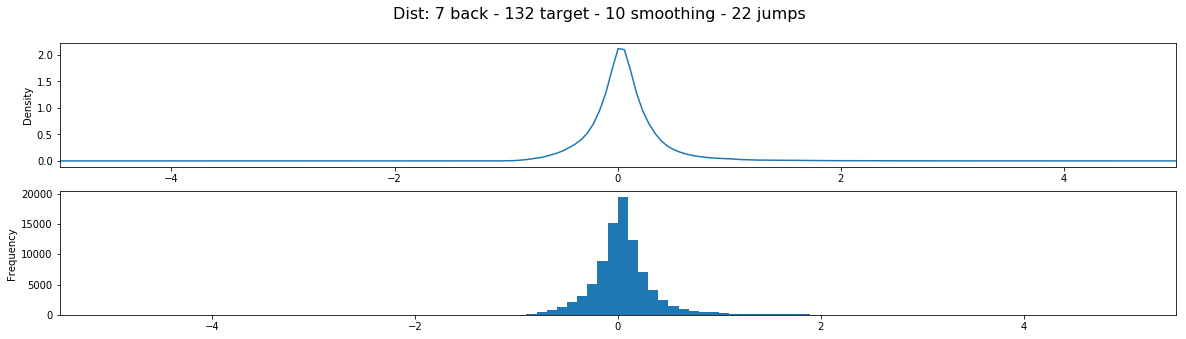

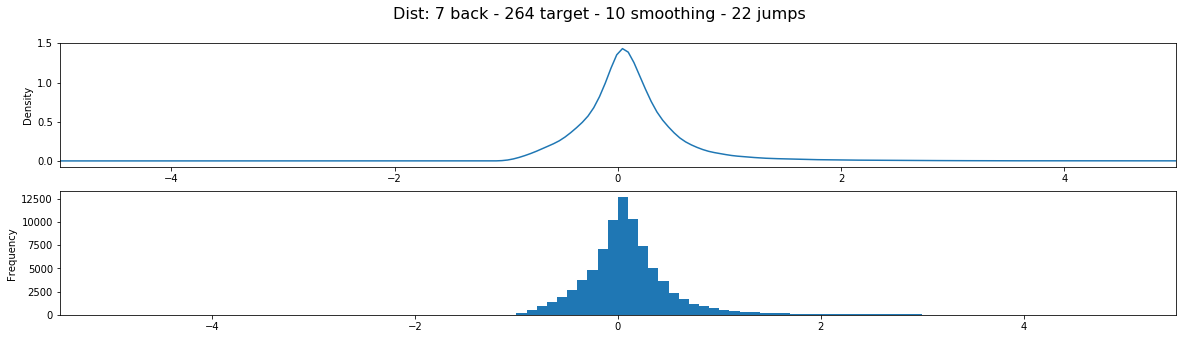

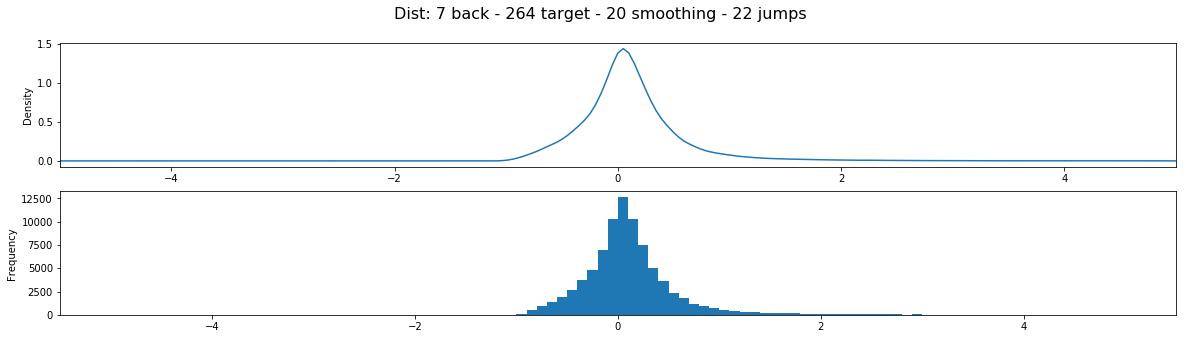

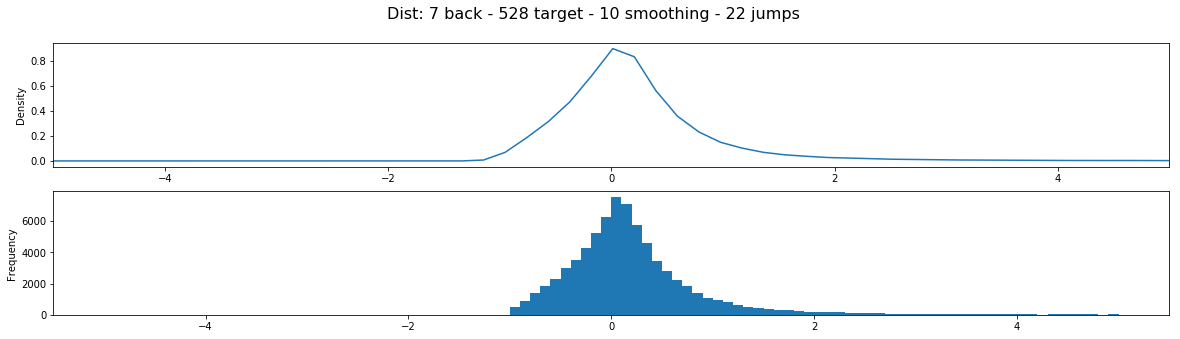

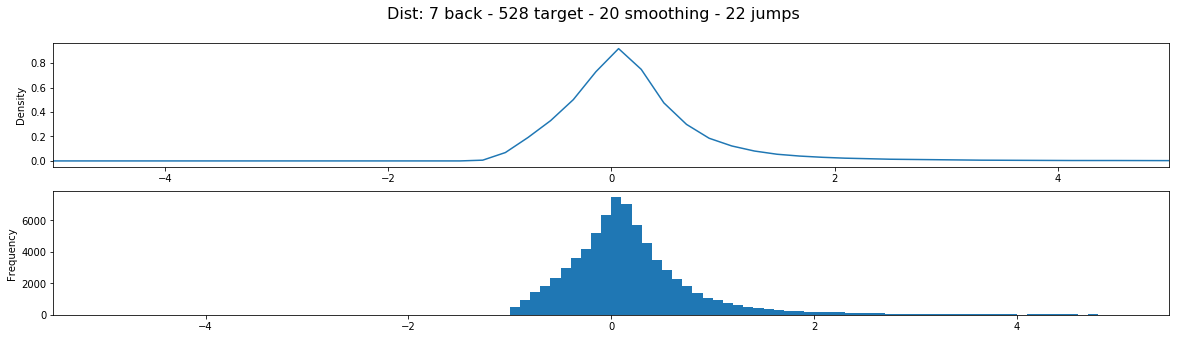

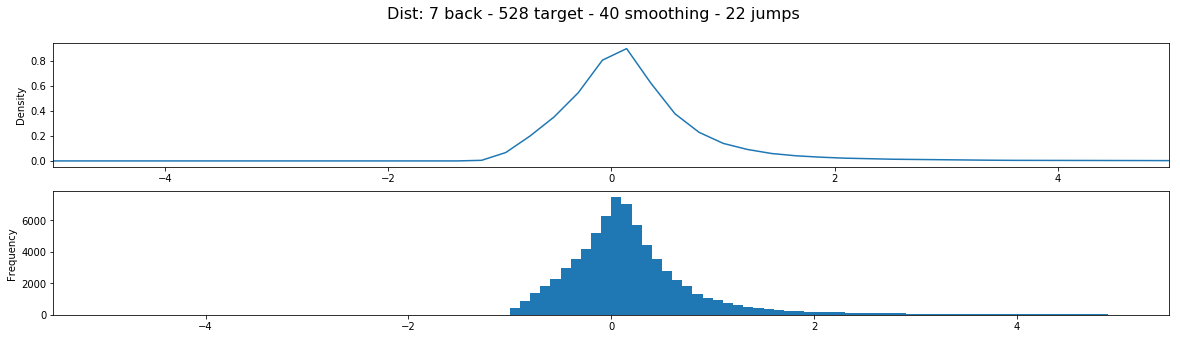

In [73]:
# generate distributions for various settings (expecting 22 work days per month)
jump = 22
sets = [
    (7, 22, 3, jump),
    (7, 22*3, 3, jump),
    (7, 22*3, 5, jump),
    (7, 22*6, 5, jump),
    (7, 22*6, 10, jump),
    (7, 22*12, 10, jump),
    (7, 22*12, 20, jump),
    (7, 22*24, 10, jump),
    (7, 22*24, 20, jump),
    (7, 22*24, 40, jump),
]

for s in sets:
    get_target_dist(s[0], s[1], s[2], s[3])

From the target value distribution, we can see multiple things:

* The distributions follows the pattern of a normal distribution centered around 0
* smoothing does not seem to have a notable impact
* We can see, that the distribution has higher variance as we look over longer time spans (as expected)
* As stocks cannot retrieve negative values, the negative part of the distribution cuts at -1 (which is a 100% value decline) - can be seen especially in the last distribution

This means that we will have to use adaptive value clipping based on the forcast length for the model we want to train. Our next steps will be to perform clipping and categorization of the values and look at the correlation matrix between different values to check for fundamental differences in the input data (i.e. is the historical input data actually suited to predict future prices)

[-0.5  -0.25  0.    0.25  0.5 ]


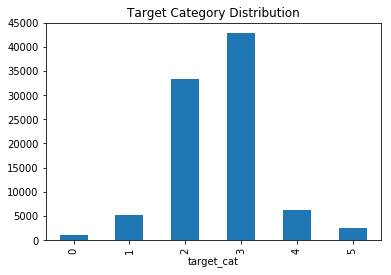

In [74]:
# function to perform categorization based on given limits
def categorize(df, xlim, num_cats=6, debug=True):
    '''Performs categorization of the target values in the data.
    
    Args:
        df (DataFrame): DataFrame that contains the datapoints and a value of the target values
        xlim (tuple): tuple of limit values for the min and max values
        num (int): Number of categories to apply (2 categories are outer)
        
    Returns:
        DataFrame with update `target` column that contains int categorical value
    '''
    # define boundaries of categories
    d = (xlim[1] - xlim[0]) / (num_cats - 2)
    cats = np.array([xlim[0] + (d*i) for i in range(0, num_cats - 1)])
    if debug: print(cats)
    
    # update the target column
    df['target_cat'] = df['target'].clip(xlim[0], xlim[1]).apply(lambda x: num_cats - 1 if x == xlim[1] else np.where((cats >= x))[0][0])
    
    return df
    
# calculate the categories
num_cats = 6
df_norm = create_dataset(df_stocks, 7, 66, 3, jump_size=22)
df_cat = categorize(df_norm, xlim=(-0.5, 0.5), num_cats=num_cats)

# visualize the categories
df_cat.groupby('target_cat').count()['symbol'].plot.bar(title='Target Category Distribution')

Now that we have categorized data, lets take a closer look at the correlation between the different categories (i.e. how different are input values for the actual target value - is there a high variance?)

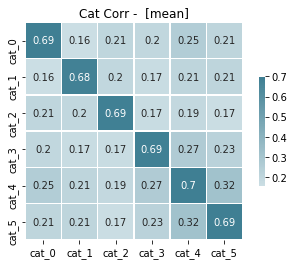

In [76]:
def visualize_corr(df_cat, name=None, num_special=3, agg='mean', method='spearman', self_special=True):
    '''Function to calculate the correlation between single categories.
    
    Args:
        df_cat (DataFrame): holds relevant day values and categories
        name (str): Optional name for the title of the plot
        num_special (int): Number of special columns at the end of the dataframe
        agg (str): Defines the aggregation mechanism
    '''
    num_cats = len(df_cat['target_cat'].unique())
    # create helper retrieval function (make code shorter)
    get = lambda x: df_cat[df_cat['target_cat'] == x].iloc[:, :-num_special]

    res = []
    for i in range(num_cats):
        row = []
        for j in range(num_cats):
            if i == j and self_special:
                corr = get(i).dropna().corr(method=method).mean().agg(agg)
            else:
                corr = get(i).dropna().corrwith(get(j).dropna(), axis=0, method=method).agg(agg)
            row.append(0 if np.isnan(corr) else corr)
        res.append(np.array(row))

    cols = ["cat_{}".format(i) for i in range(num_cats)]
    df_corr = pd.DataFrame(np.array(res), columns=cols, index=cols)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    ax = plt.axes()
    sns.heatmap(df_corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=ax)
    ax.set_title("Cat Corr - {} [{}]".format("" if name is None else name, agg))
    plt.show()

visualize_corr(df_cat)

The graph above shows us the correlation values for the default distribution we have created. In order to check if stock values are just working random, we have to calculate the self-correlation as a special case, where we split the available values in two distinct sets and calculate the correlation between these sets. As we can see, the correlation appears to be uniform across all categories. There is a small trend (see the higher values in the lower right corner), which show us that positive performing stocks might be detectable through this data (but probably not with high accuracy).

To verify this, lets take a look at the correlations across a wider range of distributions (we would expect for the correlation to get more uniform as we look ahead further):

[-0.5  -0.25  0.    0.25  0.5 ]


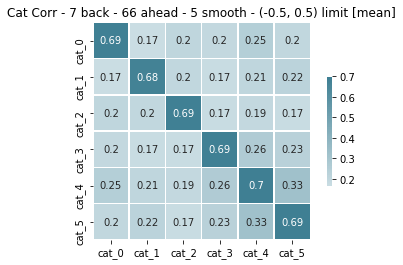

[-0.5  -0.25  0.    0.25  0.5 ]


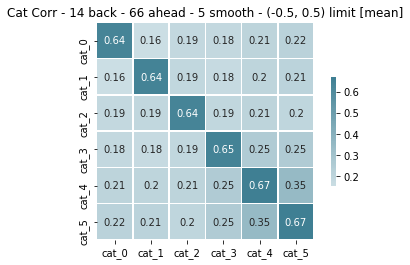

[-0.75  -0.375  0.     0.375  0.75 ]


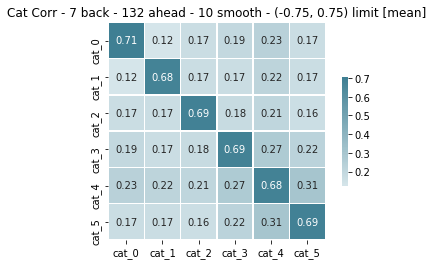

[-0.75  -0.375  0.     0.375  0.75 ]


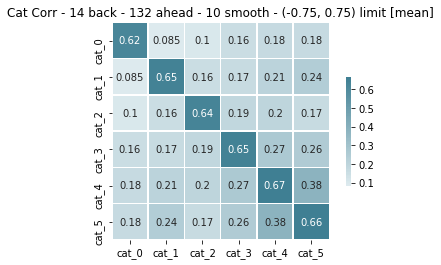

[-0.9   -0.425  0.05   0.525  1.   ]


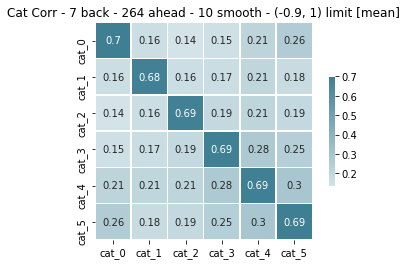

[-0.9   -0.425  0.05   0.525  1.   ]


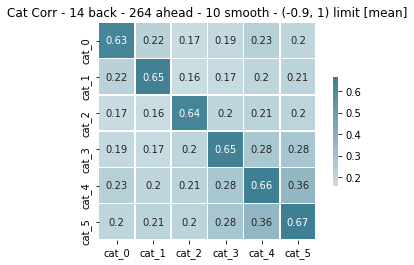

[-0.9   -0.425  0.05   0.525  1.   ]


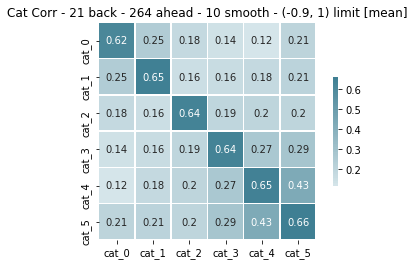

[-0.95   -0.3375  0.275   0.8875  1.5   ]


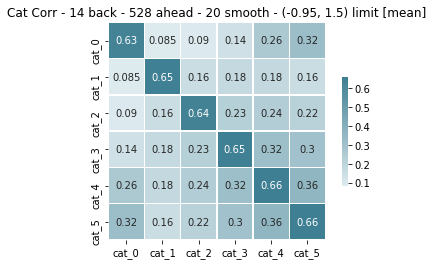

[-0.95   -0.3375  0.275   0.8875  1.5   ]


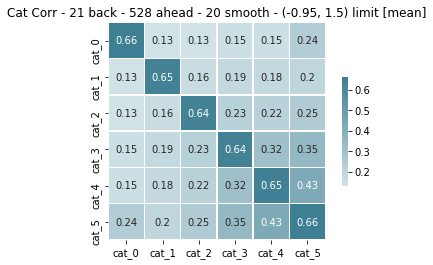

In [77]:
# create different datasets and visualize the correlations
jump = 22
sets = [
    (7, 22*3, 5, jump, (-0.5, 0.5)),
    (14, 22*3, 5, jump, (-0.5, 0.5)),
    (7, 22*6, 10, jump, (-.75, .75)),
    (14, 22*6, 10, jump, (-.75, .75)),
    (7, 22*12, 10, jump, (-.9, 1)),
    (14, 22*12, 10, jump, (-.9, 1)),
    (21, 22*12, 10, jump, (-.9, 1)),
    (14, 22*24, 20, jump, (-.95, 1.5)),
    (21, 22*24, 20, jump, (-.95, 1.5)),
]

num_cats = 6
for s in sets:
    # create dataset
    df_norm = create_dataset(df_stocks, s[0], s[1], s[2], jump_size=s[3])
    df_cat = categorize(df_norm, xlim=s[4], num_cats=num_cats)
    
    # visualize correlation
    visualize_corr(df_cat, "{} back - {} ahead - {} smooth - {} limit".format(s[0], s[1], s[2], s[4]))

> Note that the lower limit is capped before -1 as no stock decents to 0 (except in a bankruptcy, in which case the stock is not traded any more, so there are no datapoints for that case)

We can learn multiple things from these graphs:

* Longer time horizons of historic data slightly improve correlations between similar classes
* Positive stocks seem to be more correlated in historic data
* There is no clear diagonal structure (esp. stocks moving in negative direction have a low self-correlation)

This could be an indicator that stock behavior (esp. over a longer time horizon) randomizes (or at least is not strongly dependent on previous performance). (A common piece of knowledge already advocated by many trading books).

The next step will be to match training data with the relevant statements to get a better understanding of the underlying fundamentals of a company. One would expect that this increases the correlation, as it provides information commonly used by big wall street traders (e.g. Benjamin Graham, Waren Buffet or Peter Lynch).

In [78]:
sample = np.random.choice(list(stocks.keys()), 1000)

cache = rcmd.stocks.Cache()
sm = rcmd.stocks.FMPStatements()
df_state = cache.load_statement_data(sample, sm)

# alternative way
# NOTE: this will take some time
#df_state = sm.merge_records(sample)
# optional store the data
#df_state.to_csv('../data/statements_sample.csv')
print(df_state.shape)
df_state.head()

(102868, 53)


,assets_tax,assets_total,assets_total_current,assets_total_noncurrent,bookvalue_share_growth,buybacks,capital_expenditure,cash,cash_marketcap_ratio,cashflow_finance,...,research_growth,revenue,revenue_costs,revenue_deffered,revenue_growth,revenue_share_growth_10y,revenue_share_growth_3y,revenue_share_growth_5y,shareholder_equity,symbol
0,331000.0,250873000.0,15115000.0,102410000.0,NaN,137610000.0,-139000.0,226734000.0,0.1833,137610000.0,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,79567000.0,myov
1,524000.0,172977000.0,6185000.0,96670000.0,-0.9019,27248000.0,-518000.0,156074000.0,0.0337,27222000.0,...,0.9054,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4334000.0,myov
2,767000.0,201670000.0,5504000.0,99061000.0,NaN,38013000.0,-328000.0,183003000.0,0.0750,91713000.0,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,46735000.0,myov
3,767000.0,168166000.0,4633000.0,46095000.0,NaN,75001000.0,-193000.0,154317000.0,0.0638,75001000.0,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,74101000.0,myov
4,855000.0,154348000.0,4156000.0,45270000.0,NaN,79963000.0,-197000.0,143635000.0,0.0337,79963000.0,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,60155000.0,myov


In [79]:
# load stocks through the library
ti = rcmd.stocks.AlphaVantageTicker()
df_stocks = cache.load_stock_data(sample, stocks, ti)
df_stocks_ds = rcmd.learning.preprocess.create_stock_dataset(df_stocks, 14, 66, 3, jump_size=21)

print(df_stocks_ds.shape)
df_stocks_ds.head()

(100376, 17)


,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,target_price,target,symbol
date,,,,,,,,,,,,,,,,,
2008-03-17,-0.038525,-0.034463,-0.024735,-0.043234,-0.007245,0.007374,-0.020802,-0.013428,-0.006003,-0.015369,-0.015369,-0.003079,-0.006235,0.0,38.650,0.033018,pm
2008-04-16,-0.026629,-0.018912,-0.016741,-0.003531,-0.014544,0.023412,0.023412,0.009652,0.005153,0.023621,0.004290,-0.001177,0.004107,0.0,38.229,0.085242,pm
2008-05-15,0.024969,0.027553,0.032261,0.018497,0.000512,0.006319,-0.002916,-0.006242,-0.015248,0.001330,0.013636,0.003019,-0.005398,0.0,39.088,0.046649,pm
2008-06-16,-0.014409,-0.016294,-0.030497,-0.020788,-0.024300,-0.016114,-0.005810,0.005810,-0.025668,-0.031814,-0.040387,-0.020968,-0.016888,0.0,38.725,-0.136737,pm
2008-07-16,-0.014846,-0.051341,-0.055795,-0.060248,-0.031003,-0.041840,-0.023431,-0.012421,-0.020437,-0.007052,-0.006433,-0.038500,-0.030508,0.0,40.416,-0.202073,pm


In [80]:
# normalize stock data
df_stocks_cat = rcmd.learning.preprocess.categorize_stock_data(df_stocks_ds, (-.5, .5))

# normalize and merge the data
df_state_norm = rcmd.learning.preprocess.normalize_statement_data(df_state, impute=True)
df_merge = rcmd.learning.preprocess.merge_stock_statement(df_stocks_cat, df_state_norm, col_price='target_price')

# provide output
print(df_merge.shape)
df_merge.describe()

[-0.5  -0.25  0.    0.25  0.5 ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


(32912, 36)


,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,dividend_share_growth_3y,dividend_share_growth_5y,dividend_share_growth_10y,revenue_share_growth_3y,revenue_share_growth_5y,revenue_share_growth_10y,pe_ratio,cash_share,target,target_cat
count,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,...,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000,32912.000000
mean,0.001365,0.000652,0.000432,-0.000411,-0.000888,0.000027,-0.000368,-0.000003,-0.000672,-0.000316,...,0.015841,-0.008532,-0.015755,0.039379,0.024869,0.029636,59.079967,3.223578,0.039918,2.641529
std,0.116582,0.112445,0.108735,0.103704,0.099753,0.094626,0.089149,0.090644,0.084994,0.076949,...,0.272753,0.231787,0.200941,0.548115,0.174442,0.141237,322.809096,1536.327191,0.247581,0.807781
min,-0.920434,-0.920434,-0.918626,-0.913201,-0.913201,-0.904159,-0.733764,-0.707862,-0.688644,-0.679453,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-5797.000130,-23718.110905,-0.925421,0.000000
25%,-0.042628,-0.040893,-0.039104,-0.037769,-0.035714,-0.033122,-0.030451,-0.027777,-0.025462,-0.022204,...,0.000000,0.000000,0.000000,-0.036150,-0.022500,-0.010600,-1.900000,-16.817065,-0.064357,2.000000
50%,-0.005346,-0.005747,-0.004957,-0.004591,-0.004454,-0.003448,-0.003096,-0.002767,-0.002896,-0.002158,...,0.000000,0.000000,0.000000,0.036113,0.036100,0.042000,48.378059,-0.838947,0.026347,3.000000
75%,0.035570,0.033654,0.032174,0.029518,0.028262,0.027339,0.024822,0.023436,0.020425,0.018272,...,0.050300,0.034631,0.015425,0.105500,0.096113,0.091550,81.335871,4.587864,0.121309,3.000000
max,10.153846,9.384615,10.538462,10.153846,10.153846,9.461538,9.000000,10.730769,10.538462,9.769231,...,5.400500,2.110900,0.912800,43.919498,1.747700,0.855400,10534.000235,242996.250000,16.257143,5.000000


In [81]:
df_merge.head()

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,dividend_share_growth_5y,dividend_share_growth_10y,revenue_share_growth_3y,revenue_share_growth_5y,revenue_share_growth_10y,pe_ratio,cash_share,target,target_cat,symbol
date,,,,,,,,,,,,,,,,,,,,,
2009-05-27,0.047348,0.044985,0.067941,0.109930,0.090518,0.071317,0.034772,0.031439,0.008693,0.021353,...,0.5849,0.3118,0.1367,0.1141,0.1208,27.237931,-24.026043,0.069195,3,DRI
2009-05-28,0.107565,0.048146,0.056663,0.042685,0.020641,0.024299,0.027455,0.024649,0.033216,0.024299,...,0.1014,0.1233,0.0687,0.0849,0.0839,665.333348,-4.518427,0.318902,4,CTAS
2009-05-29,-0.074448,-0.032145,-0.034584,-0.060832,-0.066147,-0.055590,-0.081219,-0.063635,-0.052241,-0.030580,...,0.0000,0.0000,0.0632,0.0637,0.1173,40.395588,37.358140,0.121612,3,ACN
2009-05-29,0.014068,0.043324,0.055536,0.047768,0.076792,0.081971,0.084599,0.085720,0.087614,0.086841,...,-0.0282,0.0000,-0.0107,-0.0415,-0.0125,50.735295,-7.707728,0.271476,4,AYI
2009-05-29,0.085955,0.125843,0.131461,0.102809,0.116292,0.096067,0.077528,0.066292,0.050000,0.035955,...,0.0000,0.0000,0.0056,0.0183,0.0759,37.872341,-2.862892,0.111878,3,HELE


> Note that we do not have statements for all stocks (as some of the data goes far back) - the data is therefore already filtered for `nan` values (whereby `inf` and `-inf` are converted to `nan`).

Now that we can add normalized statement information, lets look at the correlation again. Note that as we added many new feature columns that are working (partly) independent on each other the aggregated information will most likely not provide meaningful information. To avoid this, we will look at single features:

[-0.5  -0.25  0.    0.25  0.5 ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


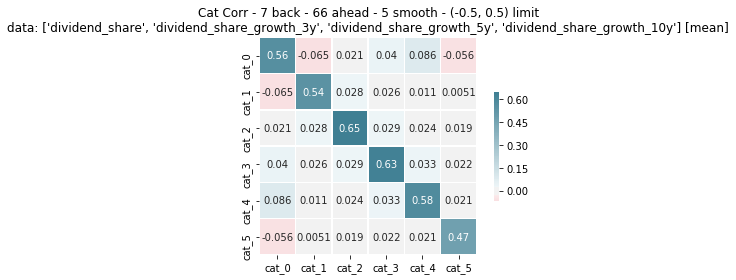

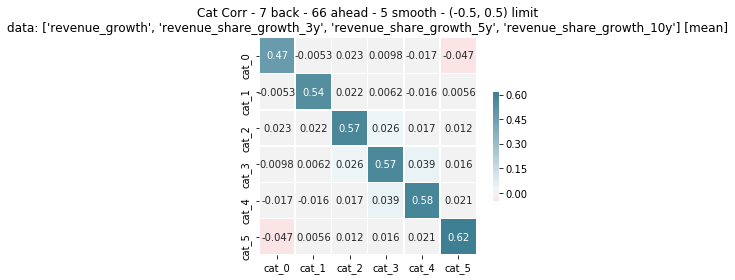

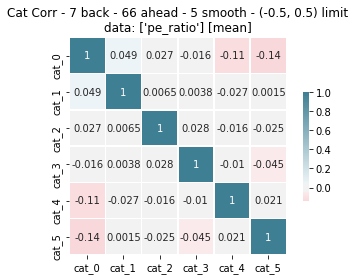

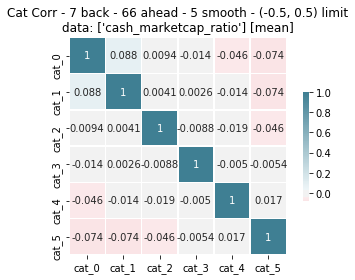

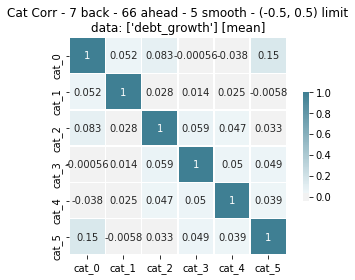

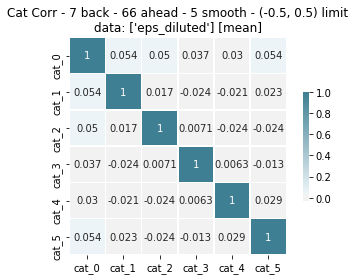

[-0.5  -0.25  0.    0.25  0.5 ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


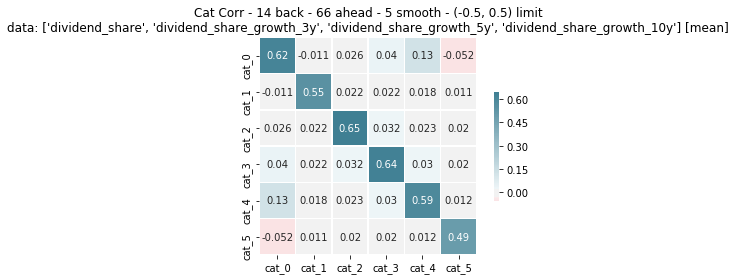

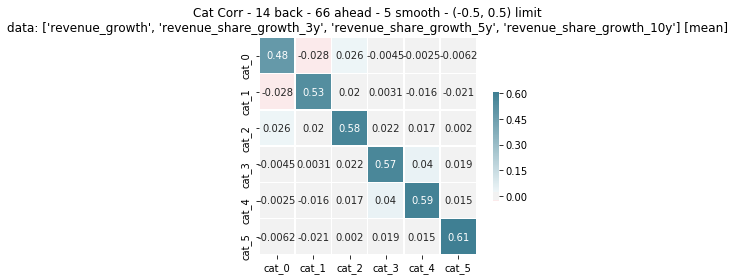

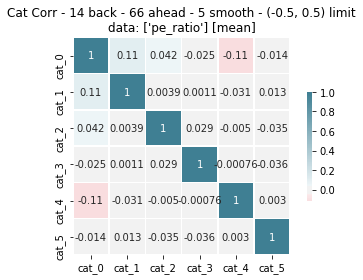

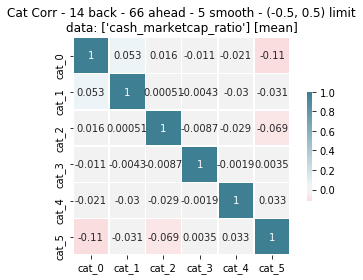

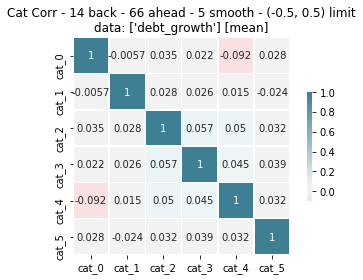

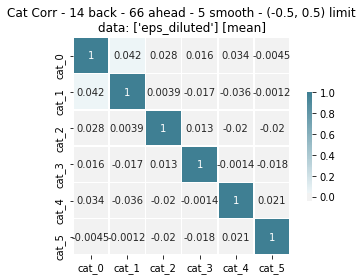

[-0.75  -0.375  0.     0.375  0.75 ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


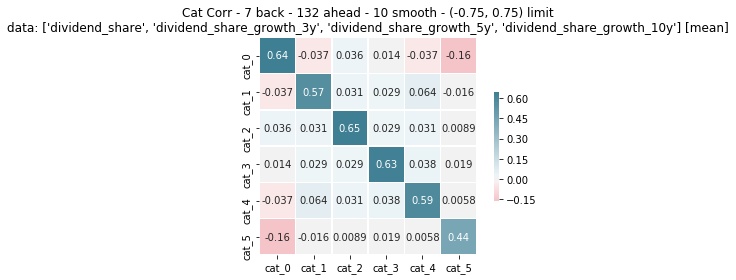

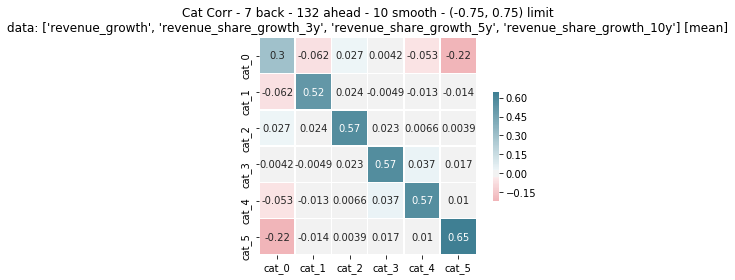

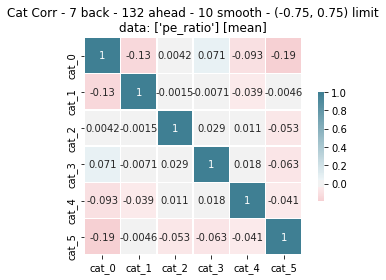

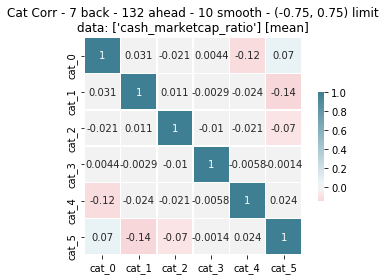

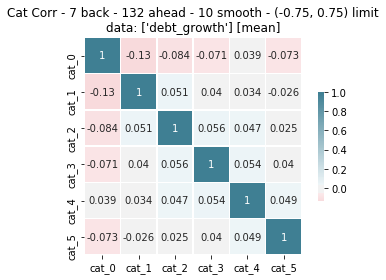

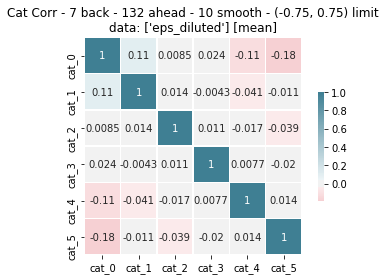

[-0.75  -0.375  0.     0.375  0.75 ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


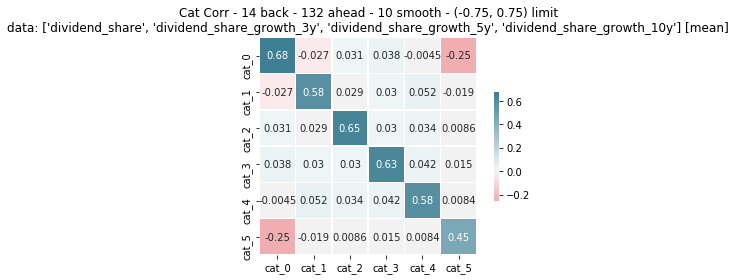

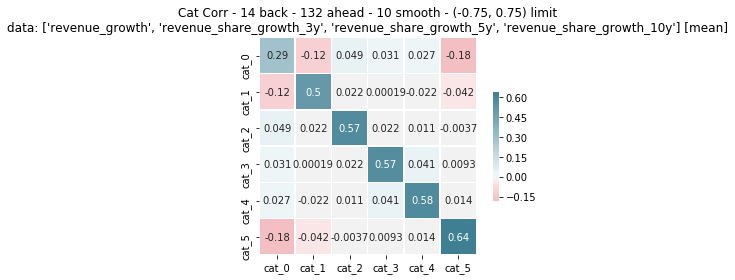

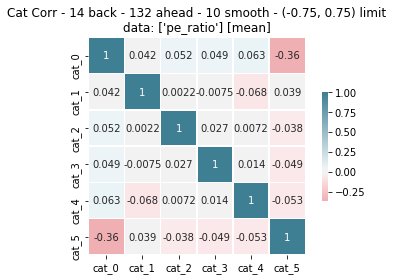

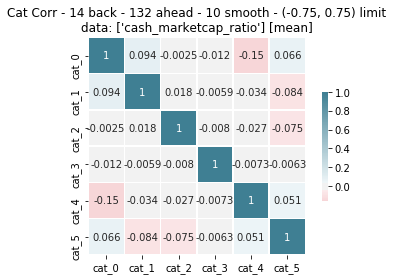

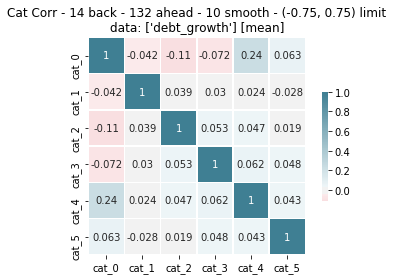

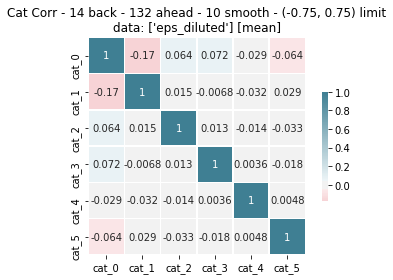

[-0.9   -0.425  0.05   0.525  1.   ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


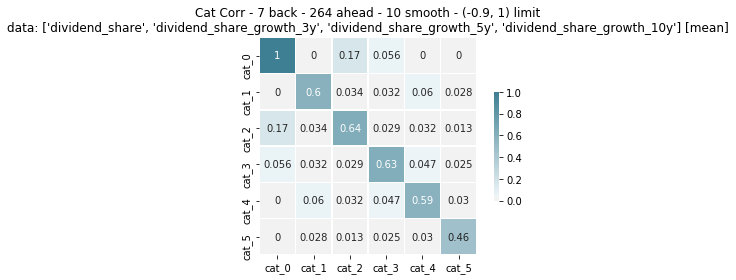

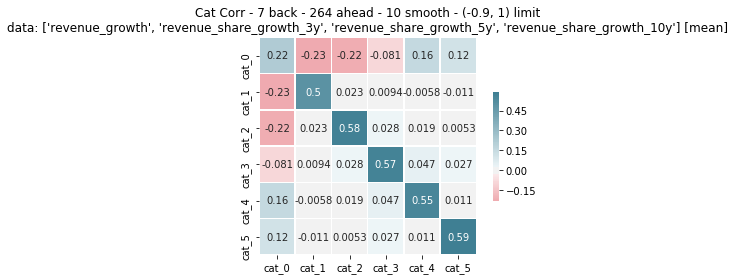

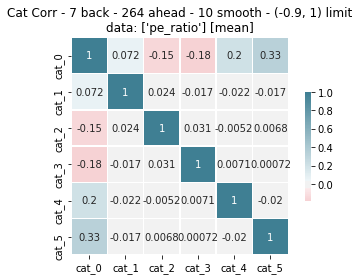

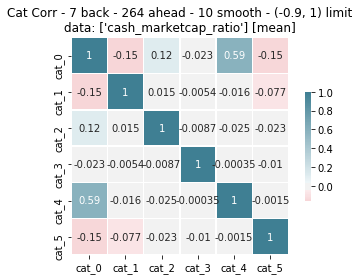

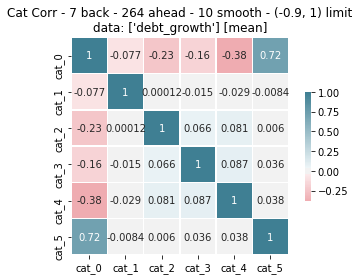

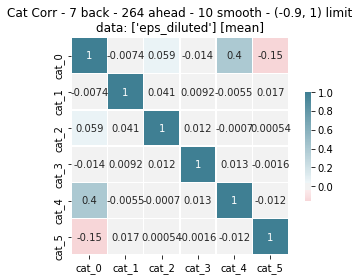

[-0.9   -0.425  0.05   0.525  1.   ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


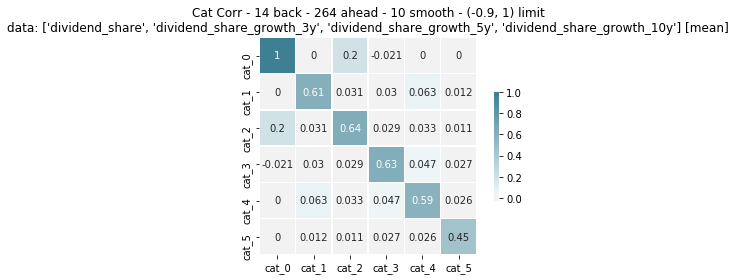

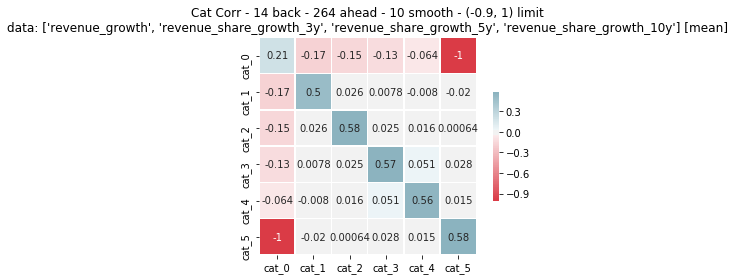

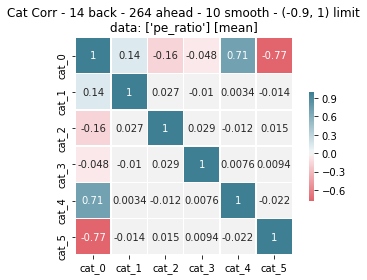

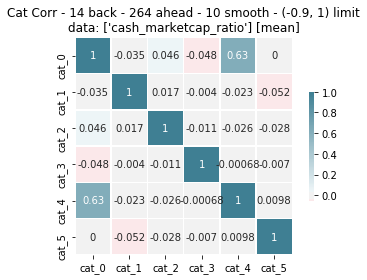

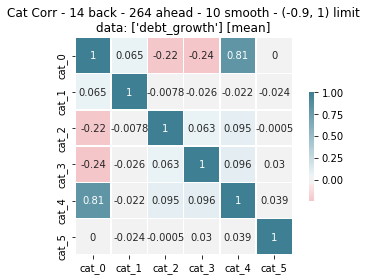

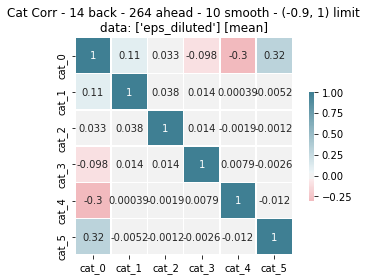

[-0.9   -0.425  0.05   0.525  1.   ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


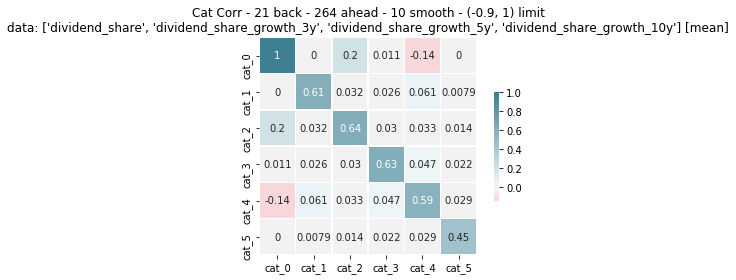

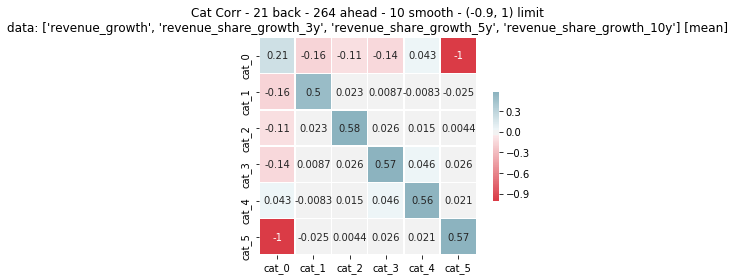

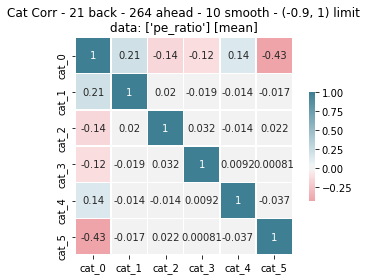

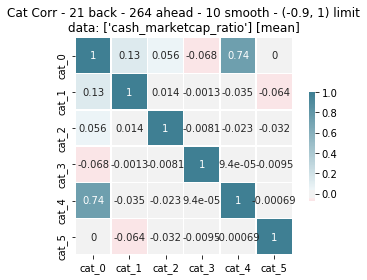

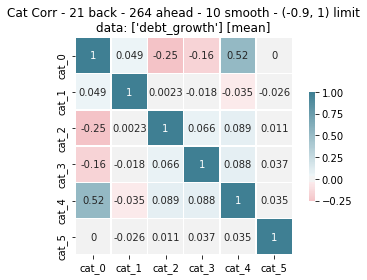

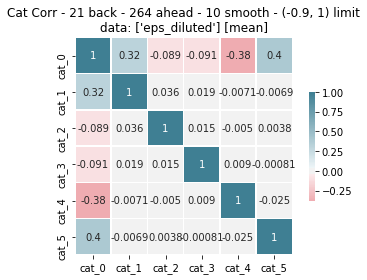

[-0.95   -0.3375  0.275   0.8875  1.5   ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


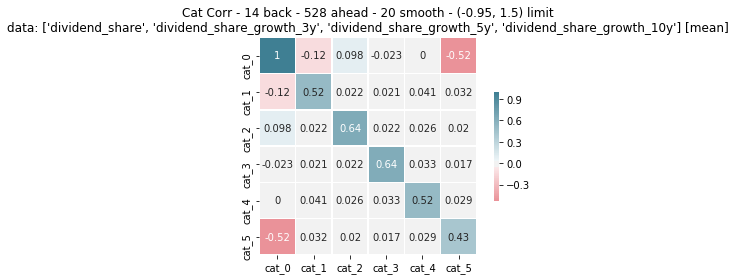

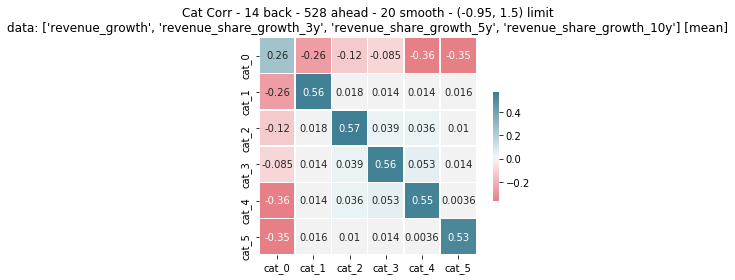

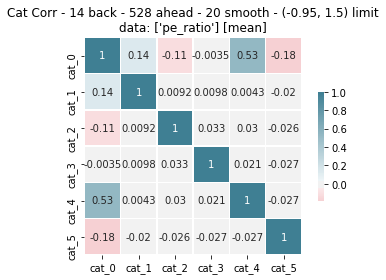

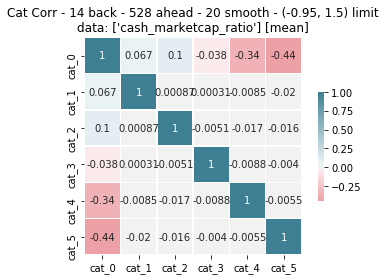

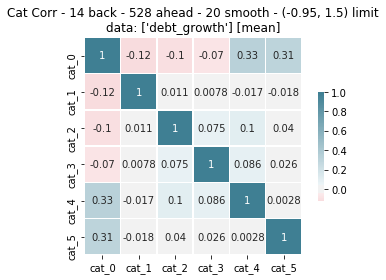

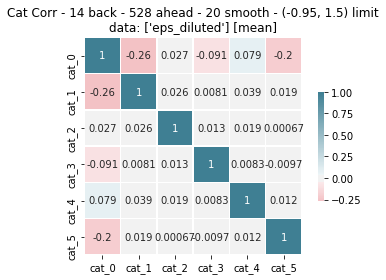

[-0.95   -0.3375  0.275   0.8875  1.5   ]


..\recommender\learning\preprocess.py:252: RuntimeWarning: divide by zero encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:252: RuntimeWarning: invalid value encountered in true_divide
  df['expenses_research_netcash'] = np.divide(df['expenses_research'], df['cash_net'])
..\recommender\learning\preprocess.py:310: RuntimeWarning: divide by zero encountered in true_divide
  # calculate the pe_ratio


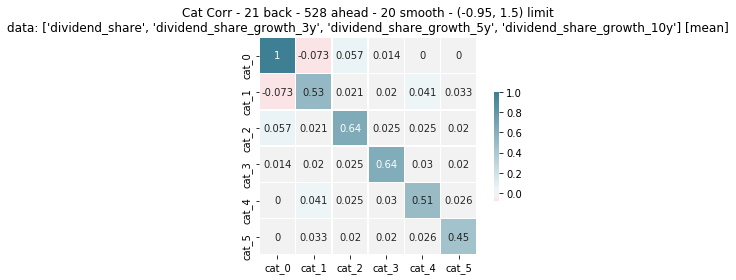

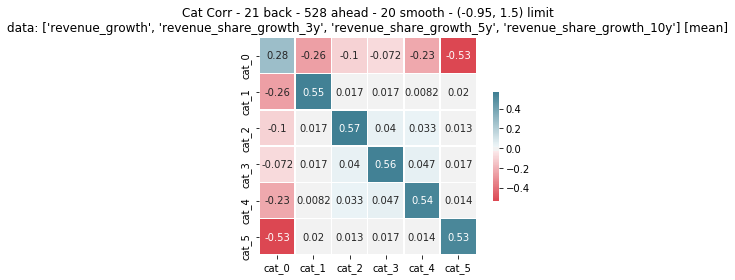

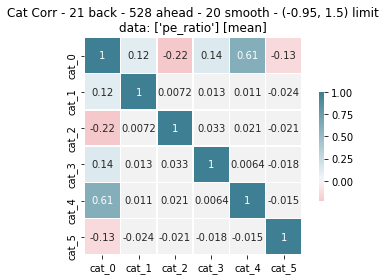

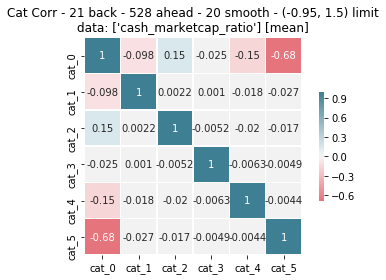

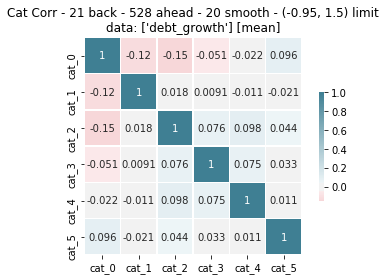

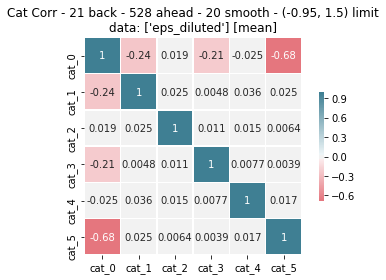

In [82]:
# create different datasets and visualize the correlations
jump = 22
sets = [
    (7, 22*3, 5, jump, (-0.5, 0.5)),
    (14, 22*3, 5, jump, (-0.5, 0.5)),
    (7, 22*6, 10, jump, (-.75, .75)),
    (14, 22*6, 10, jump, (-.75, .75)),
    (7, 22*12, 10, jump, (-.9, 1)),
    (14, 22*12, 10, jump, (-.9, 1)),
    (21, 22*12, 10, jump, (-.9, 1)),
    (14, 22*24, 20, jump, (-.95, 1.5)),
    (21, 22*24, 20, jump, (-.95, 1.5)),
]

special = ['target_price', 'target', 'target_cat', 'symbol']
rel = [
    ['dividend_share', 'dividend_share_growth_3y', 'dividend_share_growth_5y', 'dividend_share_growth_10y'], 
    ['revenue_growth', 'revenue_share_growth_3y', 'revenue_share_growth_5y', 'revenue_share_growth_10y'], 
    ['pe_ratio'],
    ['cash_marketcap_ratio'],
    ['debt_growth'],
    ['eps_diluted']
]

num_cats = 6
for s in sets:
    # create dataset
    df_norm = rcmd.learning.preprocess.create_stock_dataset(df_stocks, s[0], s[1], s[2], jump_size=s[3])
    df_stocks_cat = rcmd.learning.preprocess.categorize_stock_data(df_norm, xlim=s[4], num_cats=num_cats)
    df_state_norm = rcmd.learning.preprocess.normalize_statement_data(df_state, impute=True)
    df_merge = rcmd.learning.preprocess.merge_stock_statement(df_stocks_cat, df_state_norm, col_price='target_price')
    
    # visualize correlation
    for col in rel:
        visualize_corr(df_merge[col + special], "{} back - {} ahead - {} smooth - {} limit\ndata: {}".format(s[0], s[1], s[2], s[4], str(col)), num_special=4)

> Note that these correlations do not use special values for diagonal points

We can see from the correlation that not all features might be helpful. We can also see a problem on the diagonal data (which appears to come from 0 variance in the datasets?) - Especially EPS, dividends and revenue growth appear to be good indicators for additional performance.